In [2]:
import sys

#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
from scipy.stats import pearsonr, zscore, norm
import pandas as pd
import h5py
import pickle
import deepdish as dd
from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm
import networkx as nx
from _functions import * #import the story schema effect scoring function

import seaborn as sns

##############
##############

from tqdm import tqdm_notebook

from sklearn.cluster import KMeans



### functions to import ROIs and scores

In [3]:
def ImportSLStorySchema(roi='SL',scoretype='sl_percept_score',extra='within_modality',date=20200626):

#     main_dir = '../SchemaBigFiles/draft_PAPER'
#     scoretype = 'sl_recall_score'
    main_dir = '../../SchemaBigFiles/_PaperOutputData'
    
    ## if importing recall info
#     selection = np.ones((31,dtype=bool) if scoretype=='sl_percept_score' else has_R

    path = os.path.join(main_dir,scoretype)
#     date = 20200622
#     date = 20200626

#     roi = 'SL'
    # nROIs = 181
    nPerm = 1000

    data_labels = ['reinstatement_similarity_matrix',
                  'story_effect',
                  'schema_effect']

    
    
    if roi == 'SL' or roi == 'atlas':
        ROIlist,nROIs = GetROIlist(roi)
        rois = range(nROIs)
    else:
        rois = roi
        nROIs = len(rois)
    

#     nSubj = 30 # recall only contains 30 subj with valid data
    nEvents = 4 

    results = {}
    for hem in ['R','L']:
        results[hem] = {}
        for measure in ['story_effect','schema_effect']: #data_labels:
            results[hem][measure] = np.zeros((nROIs,nEvents,nPerm+1))
            for roi_id in tqdm_notebook(rois):
                fname = '{date}_{roi}_{roi_id:04d}_{hem}_{scoretype}_{extra}.h5'.format(date=date, roi=roi, roi_id=roi_id,
                                                                    hem=hem, scoretype=scoretype,extra=extra)

                ## average out subject and story dimension
                results[hem][measure][roi_id] = np.nanmean(np.nanmean(dd.io.load(os.path.join(path,fname), '/' + hem + '/' + measure),axis=0),axis=0)

                
    nv = 40962 #verts in fsaverage6 brain
    raw_vox = {} # raw values
    for score in ['story_effect', 'schema_effect']:
        raw_vox[score] = {}

        dd_hem = {'L':results['L'][score].mean(1), 'R':results['R'][score].mean(1)}

        dd_vox = SLtoVox(dd_hem,ROIlist, nv, zeronan=False) #convert the searchlights back to whole surface brain

        for hem in ['L','R']:
            raw_vox[score][hem] = dd_vox[hem][:,0] #
            

    return raw_vox


        

In [4]:
def ImportSLRegressions(roi='SL',regressor='percept',modeltype='predict_rubric',extra='within_modality',date=20200715):

#     regressor = 'percept'#'recall'

    path = '../../SchemaBigFiles/_PaperOutputData/{}_{}_score_predictions/'.format(roi.lower(),regressor)
#     date = 20200626 #sys.argv[1] # 'date label to use'
#     date = 20200712
#     date = 20200715
#     roi='SL'
    # hem = 'L'#sys.argv[2] # 'L' or 'R'
    # roi = 'SL'#sys.argv[3] # 'STS', 'SL', 'atlas'
    # roi_id = 12#166 #int(sys.argv[4]) # "9999" or int

    scoretype = '{}_{}_score'.format(roi.lower(),regressor) #sy
#     modeltype = 'predict_rubric' # "predict_0f_wv_schema"  / "predict_rubric"  / 'predict_raw_wv_schema'

#     ROIlist, nROIs = GetROIlist(roi)
    # GetMissingROIs(fname)
    
        
    if roi == 'SL' or roi == 'atlas':
        ROIlist,nROIs = GetROIlist(roi)
        rois = range(nROIs)
    else:
        rois = roi
        nROIs = len(rois)

    nSubj = 31 #perception data contains 31 full subjects
    nEvents = 4 

    results = {}
    for hem in ['R','L']:
        results[hem] = {}
        for measure in ['story_effect','schema_effect','story_corr','schema_corr']: #data_labels:
            results[hem][measure] = np.zeros((nROIs,nPerm+1))
            for roi_id in tqdm_notebook(range(nROIs)):
                fname = '{date}_{roi}_{roi_id:04d}_{hem}_{scoretype}_{modeltype}_{extra}.h5'.format(
                                                                date=date, 
                                                                roi=roi, 
                                                                roi_id=roi_id,
                                                                hem=hem, 
                                                                scoretype=scoretype,
                                                                modeltype = modeltype,
                                                                extra=extra)

                ## average out subject and story dimension
    #             results[hem][measure][roi_id] = np.nanmean(np.nanmean(dd.io.load(os.path.join(path,fname), '/' + hem + '/' + measure),axis=0),axis=0)
                results[hem][measure][roi_id] = dd.io.load(os.path.join(path,fname), '/' + hem + '/' + measure)


    nv = 40962 #verts in fsaverage6 brain
    raw_vox = {} # raw values
    r_vox = {} #raw correlation values

    for score in ['story_effect', 'schema_effect']:
        raw_vox[score] = {}

        dd_vox = SLtoVox({'L':results['L'][score], 'R':results['R'][score]},ROIlist, nv, zeronan=False) #convert the searchlights back to whole surface brain    

        for hem in ['L','R']:
            raw_vox[score][hem] = dd_vox[hem][:,0] #

    ## raw correlation values into surface whole brain    
    for corr in ['story_corr', 'schema_corr']:
        r_vox[corr]  = SLtoVox({'L': results['L'][corr][:,0],'R':results['R'][corr][:,0]}, ROIlist, nv, zeronan=False) #convert SLs to surface verts

    return raw_vox,r_vox

### import all the scores

- will take a bit to load up all the SLs.

In [6]:
date = 20211014

percept = ImportSLStorySchema('SL','sl_percept_score',date=date)
recall = ImportSLStorySchema('SL','sl_recall_score',date=date)
percept_reg_raw_vox, percept_reg_r_vox = ImportSLRegressions(roi='SL',regressor='percept',modeltype='predict_rubric',date=date)
recall_reg_raw_vox, recall_reg_r_vox = ImportSLRegressions(roi='SL',regressor='recall',modeltype='predict_rubric',date=date)


### save the scores

 - Save the scores to avoid wait-time when re-loading them piece by piece.

In [7]:
path = os.path.join('../_data/kmeans')
if not os.path.exists(path):
    print("...making directory: ", path)
    os.makedirs(path)    
else:
    print("...directory exists: ", path)
    
saveObject(os.path.join(path,"percept_sl.pkl"),percept)
saveObject(os.path.join(path,"recall_sl.pkl"),recall)
saveObject(os.path.join(path,'percept_reg_raw_vox_sl.pkl'),percept_reg_raw_vox) 
saveObject(os.path.join(path,'percept_reg_r_vox_sl.pkl'),percept_reg_r_vox)
saveObject(os.path.join(path,'recall_reg_raw_vox_sl.pkl'),recall_reg_raw_vox)
saveObject(os.path.join(path,'recall_reg_r_vox_sl.pkl'),recall_reg_r_vox)

...making directory:  ../_data/kmeans


In [82]:
openObject("percept_sl.pkl")

{'story_effect': {'L': array([0.05816026, 0.09619084, 0.04872902, ..., 0.10564838, 0.10574543,
         0.10436421]),
  'R': array([0.09407675, 0.12199436, 0.07004641, ..., 0.06503289, 0.06632364,
         0.06627987])},
 'schema_effect': {'L': array([-0.01393224,  0.00294676, -0.00356365, ...,  0.01429416,
          0.01282103,  0.01111812]),
  'R': array([-0.0124846 ,  0.01464324, -0.01166967, ...,  0.00725555,
          0.00688349,  0.00585847])}}

## open the scores

In [8]:
percept = openObject(os.path.join(path,"percept_sl.pkl"))
recall = openObject(os.path.join(path,"recall_sl.pkl"))
percept_reg_raw_vox = openObject(os.path.join(path,'percept_reg_raw_vox_sl.pkl'))
percept_reg_r_vox = openObject(os.path.join(path,'percept_reg_r_vox_sl.pkl'))
recall_reg_raw_vox = openObject(os.path.join(path,'recall_reg_raw_vox_sl.pkl'))
recall_reg_r_vox = openObject(os.path.join(path,'recall_reg_r_vox_sl.pkl'))

### stack the scores for cluster analysis

In [9]:
stacks = {}
for hem in ['L','R']:
    stacks[hem] = {}
    stack = np.column_stack((
        
        ## story / schema scores
        percept['story_effect'][hem],
        percept['schema_effect'][hem],
        recall['story_effect'][hem],
        recall['schema_effect'][hem],
        
        ## corr
        percept_reg_r_vox['story_corr'][hem], #percept_reg_r_vox['story_corr'][hem]
        percept_reg_r_vox['schema_corr'][hem],
        recall_reg_r_vox['story_corr'][hem],
        recall_reg_r_vox['schema_corr'][hem],
        
        ## r^s
#         percept_reg_raw_vox['story_effect'][hem], #percept_reg_r_vox['story_corr'][hem]
#         percept_reg_raw_vox['schema_effect'][hem],
#         recall_reg_raw_vox['story_effect'][hem],
#         recall_reg_raw_vox['schema_effect'][hem]
    ))
    
    stacks[hem] = stack

In [10]:
stacks[hem].shape

(40962, 8)

### sillhouette


In [12]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For k = 2 The average silhouette_score is : 0.39305420798076207
For k = 3 The average silhouette_score is : 0.3789954691126871
For k = 4 The average silhouette_score is : 0.36125348309365457
For k = 5 The average silhouette_score is : 0.33350220158785754
For k = 6 The average silhouette_score is : 0.3320719650560491
For k = 7 The average silhouette_score is : 0.33419876668079734
For k = 8 The average silhouette_score is : 0.3401353719505998


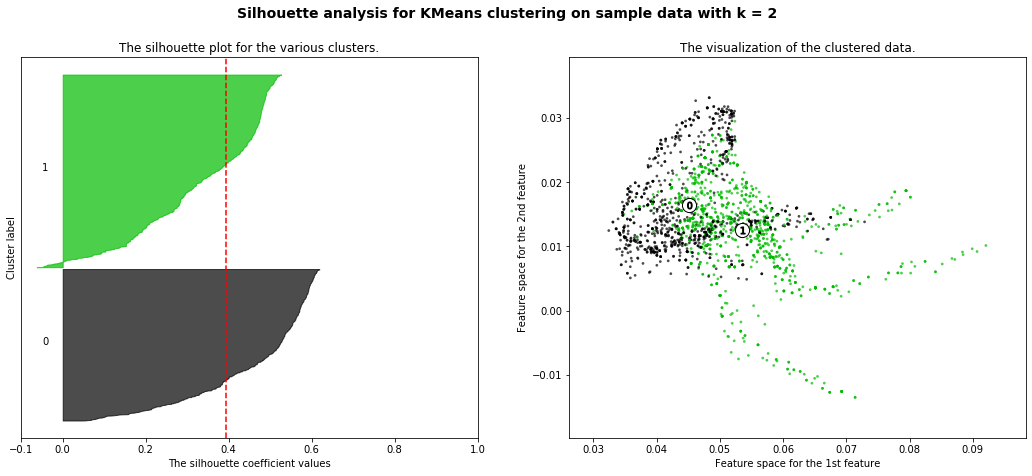

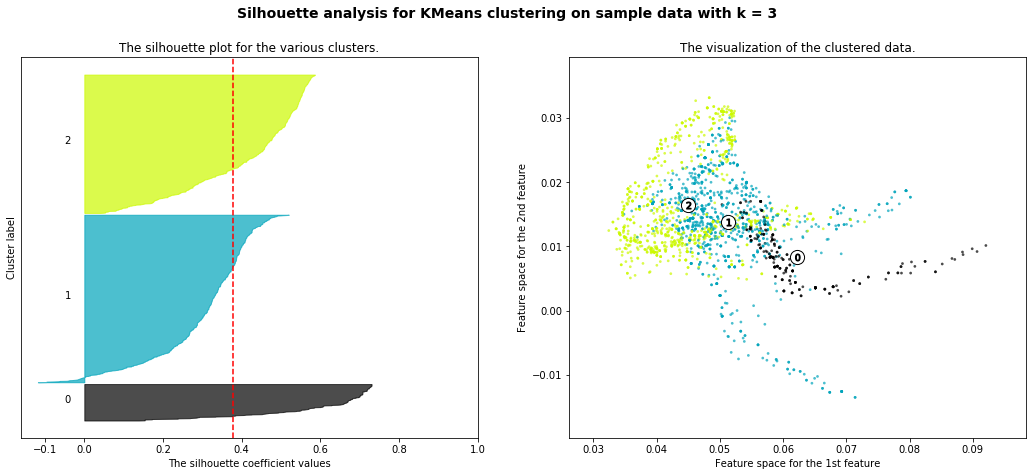

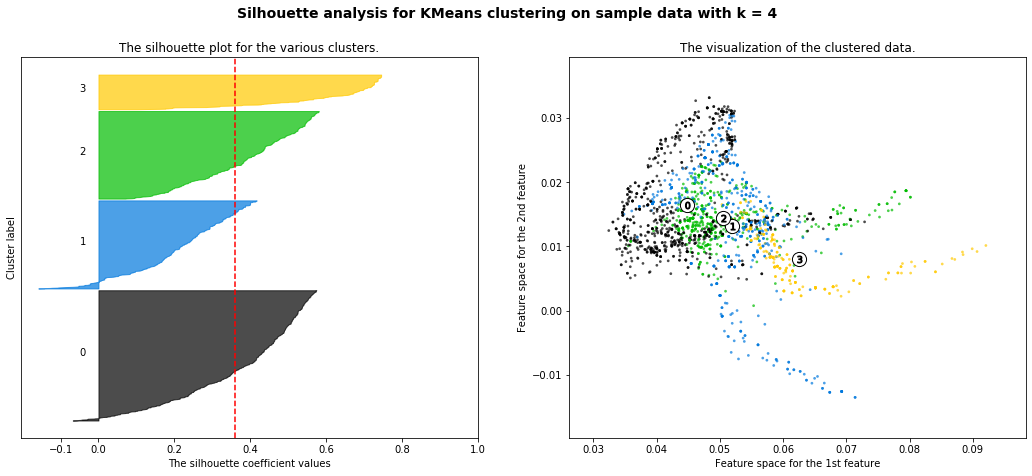

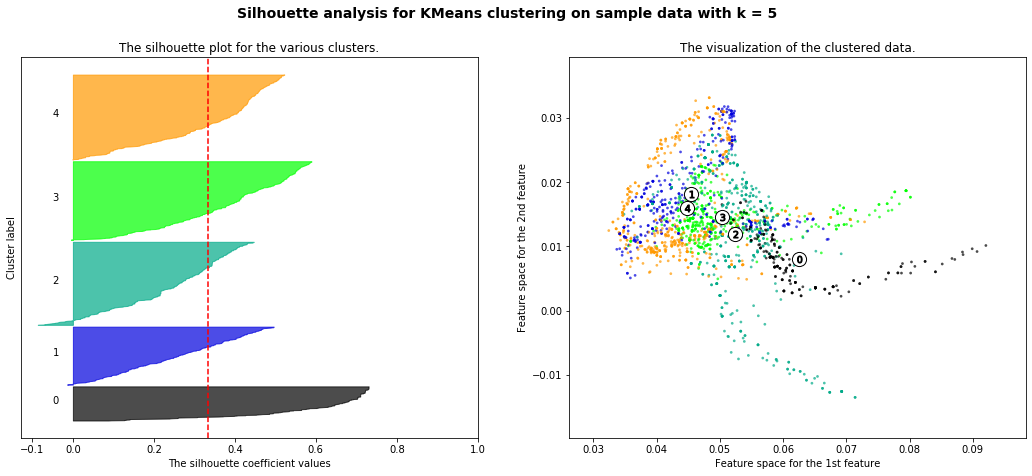

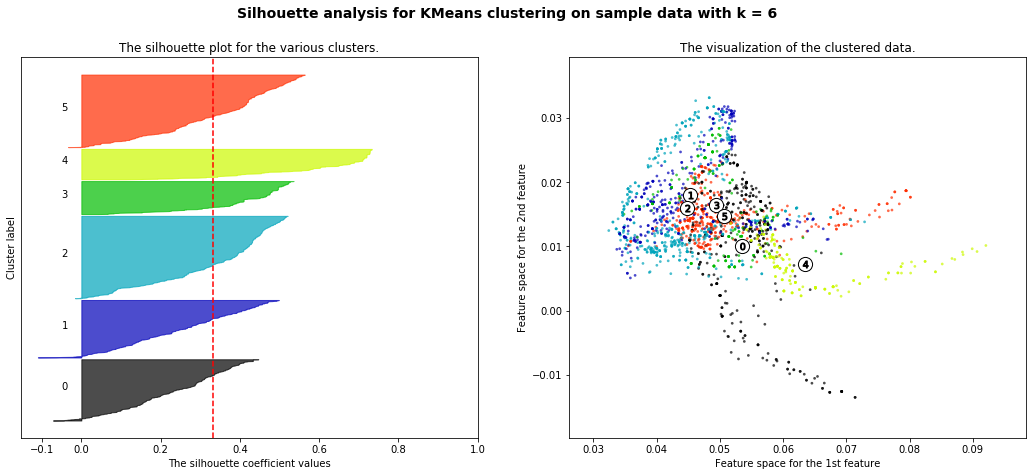

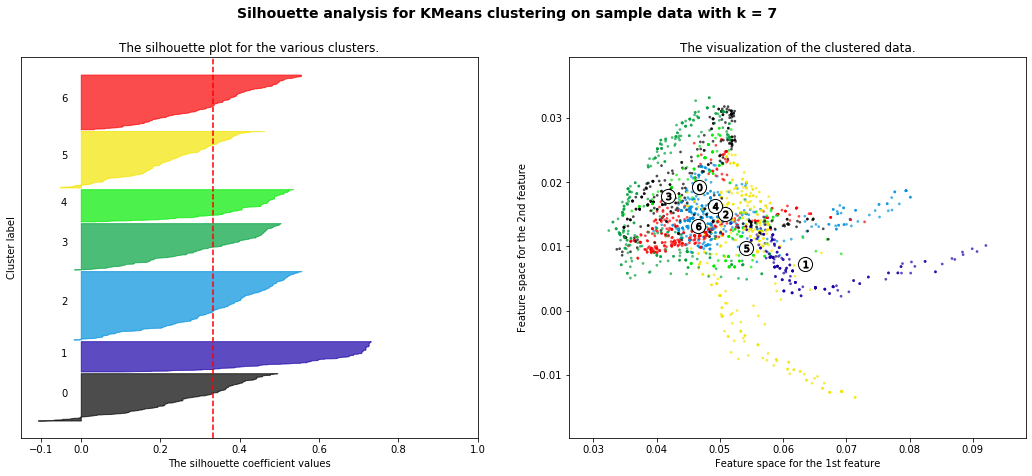

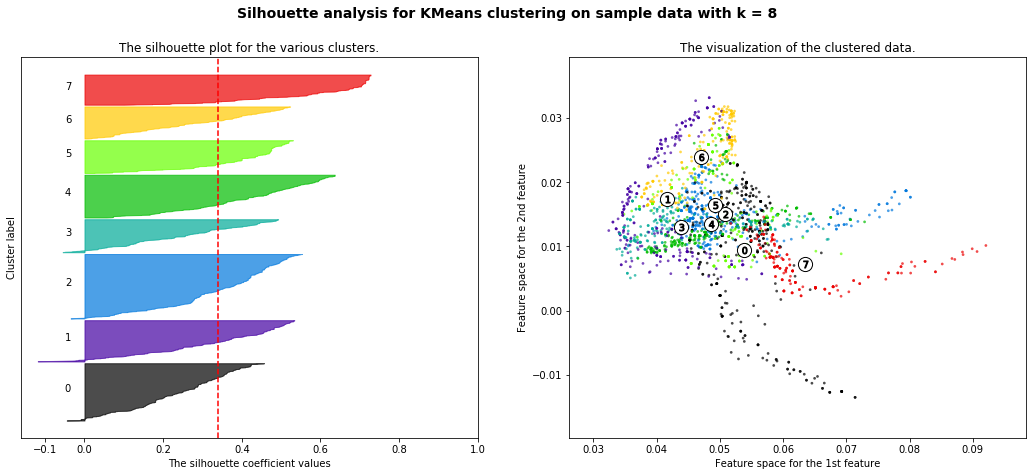

using winning cluster size k:  2


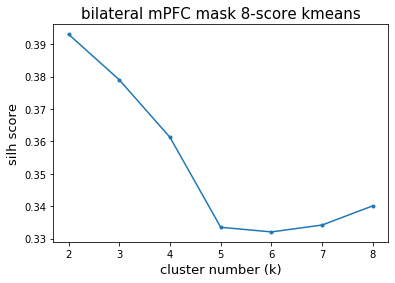

In [32]:

################################ 
##### make big mPFC mask per hemisphere
##########
ROI = 'mPFC'
roi_id = 9999


roi_verts_by_hem = {}
for hem in ['L','R']:
    roi_verts_by_hem[hem] = []
    for roi in [ROI]:#,'MP','AT']:
        roi_verts_by_hem[hem].append(ExtractROI(ROI,roi_id,hem))# = ~np.isnan(roi_verts_by_hem[hem]) * ~np.isnan(ExtractROI())
    
    roi_verts_by_hem[hem] = np.any((roi_verts_by_hem[hem]),axis=0)
    

k = 3
k_range = [2,3,4,5,6,7,8]
sils = []

# k_range = [2]

km_labels={}
for k in k_range:

    ################################ 
    ##### concatenate hemispheres with selected ROI
    ##########

    nv = 40962
    concat = np.empty((nv*2,stacks[hem].shape[1])) #create a brain x scores array, 
    concat_verts = np.empty((nv*2)) # whole brain array
    for hem in ['L','R']:
        add = nv if hem == 'R' else 0
#         print(add)
        concat[np.arange(add,nv+add)] = stacks[hem] #(81924 full brain, 8 neural scores); 
        concat_verts[np.arange(add,nv+add)] = roi_verts_by_hem[hem]

    ################################ 
    ###### find overall valid_vertices and intersection with mPFC mask
    ##########

    valid_verts = ~np.any(np.isnan(concat),axis=1) 
    valid_verts = np.logical_and(valid_verts,concat_verts)
    indeces_L = np.where(valid_verts[:nv])[0] #np.arange(40962)[valid_verts]
    indeces_R = np.where(valid_verts[nv:nv+nv])[0] #np.arange(40962)[valid_verts]
    
    
    
    ################################ 
    ##### SET UP kmeans object
    ##########
    km = KMeans(
        n_clusters=k, init='random',
        n_init=100, max_iter=500, 
        tol=1e-04, random_state=1
    )

    km_labels[k] = km.fit_predict(concat[valid_verts])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

#     print(indeces_L.shape)

   # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(concat[valid_verts], km_labels[k])
    sils.append(silhouette_avg)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(concat[valid_verts], km_labels[k])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[km_labels[k] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(km_labels[k].astype(float) / k)
    ax2.scatter(concat[valid_verts][:, 0], concat[valid_verts][:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with k = %d" % k),
                 fontsize=14, fontweight='bold')
plt.show()    

################################ 
###### plot the results
##########

plt.plot(sils,'.-')
plt.xticks(range(len(k_range)),k_range);
plt.xlabel("cluster number (k)",fontsize=13)
plt.ylabel("silh score",fontsize=13)
plt.title("bilateral mPFC mask 8-score kmeans",fontsize=15);
    
################################ 
###### re-convert clusters to brain hemispheres separately
##########

k = k_range[np.argmax(sils)]

print('using winning cluster size k: ',k)

brain = {}
for hem in ['L','R']:

    km_inds = np.arange(indeces_L.shape[0]) if hem == 'L' else np.arange(indeces_L.shape[0],indeces_L.shape[0]+indeces_R.shape[0])
    brain_inds = indeces_L if hem =='L' else indeces_R
    brain[hem] = np.full(40962,fill_value=np.nan)
    brain[hem][brain_inds] = km_labels[k][km_inds]

    


In [33]:
ls ../_data/ROIs

Ang_verts.h5    mPFC_verts.h5  PMC_verts.h5  SLlist_c10.h5
hippo_verts.h5  PHC_verts.h5   SFG_verts.h5


In [34]:
roi_dir = '../_data/ROIs'
saveObject(os.path.join(roi_dir,"{}_clusters.pkl".format(ROI)), brain) # save full brain pkl with cluster numbers as values for later visualization

################################ 
###### save results to a .h5 file as an ROI
##########

for c in range(k):
    f = os.path.join(roi_dir,"{}_k{}_c{}_verts.h5".format(ROI,k,c))
    with h5py.File(f, 'w') as hf:
        for hem in ['L','R']:
            hemi = 'left' if hem == 'L' else 'right'
            hf.create_dataset(hemi,data= np.where(brain[hem]==c)[0])

    print(f)


print('saved.')

../_data/ROIs/mPFC_k2_c0_verts.h5
../_data/ROIs/mPFC_k2_c1_verts.h5
saved.


In [42]:
np.invert(np.isnan(brain['L'])).sum()

1026